In [1]:
# Adapted from Interstellar Technologies Inc. All Rights Reserved.

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
import pandas as pd

class Rocket:
    g0 = 9.80665  # Gravitational acceleration on Earth surface [m/s^2]

    def __init__(self):
        
        self.M_0 = 50 #launch mass [kg]
        
        self.M_dry = 1  # dry mass [kg]
        
        self.M_f_guess = self.M_0*0.75
        
        self.r = (6*25.4*0.001/2) # body tube radius, [m]
        self.sref = np.pi*self.r**2  # area [m2]
        
        
        self.Isp = 200.0  # Isp [s]
        
        self.thrust_to_weight = 10  # initial thrust to weight ratio
        #self.T_max = self.thrust_to_weight * self.M_0 * self.g0
        
        self.T_max = 750;
        self.T_min = 0.3*self.T_max;
        
        
        self.h_0 = 5; #5 meters off the launch rail 
        self.v_0 = 30; #assume it reaches 30m/s off the launch rail
        self.h_f = 3000;
        self.v_f = 0;
        
        

    def air_density(self, h):
        beta = 1/8500.0  # scale factor [1/m]
        rho0 = 1.225  # kg/m3
        return rho0*np.exp(-beta*h)
    
    def speed_of_sound(self, h):
        #assumes h  is in meters, returns in m/s
        #determined from https://www.engineeringtoolbox.com/elevation-speed-sound-air-d_1534.html
        return -0.00389*h + 340.31598
    
    def drag(self, h, V):
        
        rho = self.air_density(h)
        a   = self.speed_of_sound(h)
        M   = V/a
        cd  = self.drag_coeff(M)
        
        q = (1/2)*rho*V**2
        
        drag = q*self.sref*cd
        
        return drag
        
    def drag_coeff(self, M):
        #polynomials determined from open_rocket export of rocket sized like U waterloo's 2018 rocket.
        #reference area is the rocket cross section. Data generated for 6 in diameter body tube. 
        
        def drag_coeff_single(M):
            
            coeff_sub = [ 0.62974538, -0.01151512,  0.11773826]
            coeff_tra = [-3.52610503,  7.99357459, -3.72820877]
            coeff_sup = [ 1.09641739, -0.45894398,  0.07741472]
            
            if M<1:
                coeff = coeff_sub
            elif M>1.25:
                coeff = coeff_sup
            else:
                coeff = coeff_tra
                
            cd = np.polynomial.polynomial.polyval(M,coeff)
            
            return cd
        
        M = np.array(M)
        
        if M.size == 1:
            #act on a single data point
            return drag_coeff_single(M)
        
        else:
            #assumes M is a vector
            cd = np.array([drag_coeff_single(mi) for mi in M])
            return cd

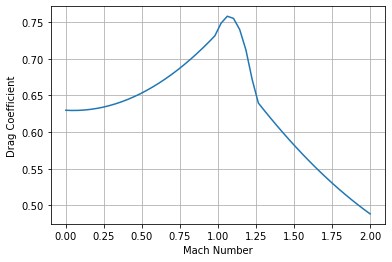

In [2]:
#verify drag model
rocket = Rocket()
M =np.linspace(0,2)
cds=rocket.drag_coeff(M)
plt.plot(M,cds)
plt.grid(True)
plt.xlabel('Mach Number')
plt.ylabel('Drag Coefficient');

In [3]:
[rocket.T_min, rocket.T_max]

[225.0, 750]

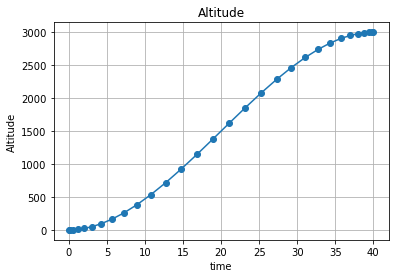

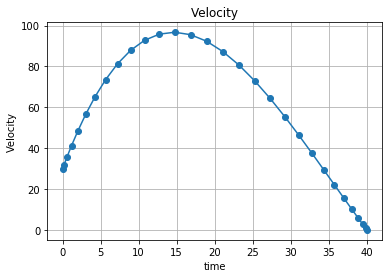

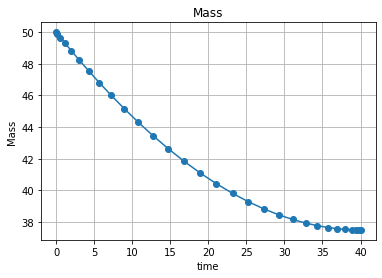

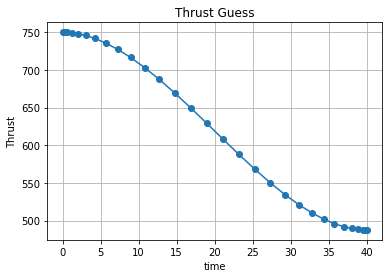

In [4]:
def dynamics(prob, obj, section):
    h = prob.states(0, section)
    v = prob.states(1, section)
    m = prob.states(2, section)
    
    T = prob.controls(0, section)
    
    drag = obj.drag(h,v)

    Isp = obj.Isp
    g0  = obj.g0
    
    dx = Dynamics(prob, section)
    dx[0] = v
    dx[1] = (T - drag) / m - g0
    dx[2] = - T / (Isp*g0)
    
    return dx()


def equality(prob, obj):
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    T = prob.controls_all_section(0)
    
    tf = prob.time_final(-1)

    result = Condition()

    # event condition
    result.equal(h[0], obj.h_0)
    result.equal(v[0], obj.v_0)
    result.equal(m[0], obj.M_0)
    
    result.equal(h[-1], obj.h_f)
    result.equal(v[-1], obj.v_f)
    

    return result()


def inequality(prob, obj):
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    T = prob.controls_all_section(0)
    tf = prob.time_final(-1)

    result = Condition()
    # lower bounds
    result.lower_bound(h, 0)
    result.lower_bound(v, 0.0)
    result.lower_bound(m, obj.M_dry)
    result.lower_bound(T, obj.T_min)
    result.lower_bound(tf, 10)
    
    # upper bounds
    result.upper_bound(m, obj.M_0)
    result.upper_bound(T, obj.T_max)
    
    #require launch rail clearance speed requirement
    #idx = np.abs(h - 5).argmin() #get time index of launch speed
    #result.lower_bound(v[idx], 30.5)
    #this method didnt work. will think of something better.
    
    #impose a minimum thrust for the first few seconds
    #v_min = 30.5 #minimum launch rail clearance speed
    #s = 5 #launch rail length
    #a_min = v_min**2/(2*s)
    #F_min = a_min*obj.M_0
    #t_min = v_min/a_min
    
    #F_min_vector = np.zeros_like(h)
    #idx = np.abs(h - s).argmin()
    #F_min_vector[0:(idx+1)] = F_min
    
    #result.lower_bound(T, F_min_vector)

    
    #result.lower_bound(T[0], obj.T_max)
    #result.lower_bound(T[1], obj.T_max)
    #result.lower_bound(T[2], obj.T_max)
    #result.lower_bound(T[3], obj.T_max)
    #result.lower_bound(T[4], obj.T_max)
    
    return result()


def cost(prob, obj):
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    
    return -m[-1]/m[0]


def cost_derivative(prob, obj):
    jac = Condition(prob.number_of_variables)
    index_h_end = prob.index_states(0, 0, -1)
    jac.change_value(index_h_end, -1)
    return jac()


# ------------------------
# create instance of operating object
obj = Rocket()

time_init = [0.0, 40]
n = [30]
num_states = [3]
num_controls = [1]
max_iteration = 20

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)



# ------------------------
# set designer unit
#unit_R = obj.Re
#unit_v = np.sqrt(obj.GMe / obj.Re)
#unit_m = obj.M0
#unit_t = unit_R / unit_v
#unit_T = unit_m * unit_R / unit_t**2
#prob.set_unit_states_all_section(0, unit_R)
#prob.set_unit_states_all_section(1, unit_v)
#prob.set_unit_states_all_section(2, unit_m)
#prob.set_unit_controls_all_section(0, unit_T)
#prob.set_unit_time(unit_t)

# ========================
# Initial parameter guess

load_csv = False

if load_csv:
    
    df = pd.read_csv('OpenGoddard_output.csv')
    
    h_init = np.interp(prob.time_all_section, df["# time"], df[" state0"])
    V_init = np.interp(prob.time_all_section, df["# time"], df[" state1"])
    M_init = np.interp(prob.time_all_section, df["# time"], df[" state2"])
    T_init = np.interp(prob.time_all_section, df["# time"], df[" control0"])    
    
else:
    h_init = Guess.cubic(prob.time_all_section, obj.h_0, 0.0, obj.h_f, 0.0)
    V_init = Guess.cubic(prob.time_all_section, obj.v_0, 10, obj.v_f, -5)
    M_init = Guess.cubic(prob.time_all_section, obj.M_0, -0.6, obj.M_f_guess, 0.0)
    T_init = Guess.cubic(prob.time_all_section, obj.T_max, 0, 0.5*(obj.T_max+obj.T_min), 0.0)


# altitude profile

Guess.plot(prob.time_all_section, h_init, "Altitude", "time", "Altitude")
# if(flag_savefig):plt.savefig(savefig_file + "guess_alt" + ".png")

# velocity

Guess.plot(prob.time_all_section, V_init, "Velocity", "time", "Velocity")

# mass profile

Guess.plot(prob.time_all_section, M_init, "Mass", "time", "Mass")
# if(flag_savefig):plt.savefig(savefig_file + "guess_mass" + ".png")

# thrust profile

Guess.plot(prob.time_all_section, T_init, "Thrust Guess", "time", "Thrust")
# if(flag_savefig):plt.savefig(savefig_file + "guess_mass" + ".png")

plt.show()


In [24]:
# ========================
# Substitution initial value to parameter vector to be optimized
prob.set_states_all_section(0, h_init)
prob.set_states_all_section(1, V_init)
prob.set_states_all_section(2, M_init)
prob.set_controls_all_section(0, T_init)

# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
# prob.cost_derivative = cost_derivative
prob.equality = equality
prob.inequality = inequality


def display_func():
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    print("max altitude: {0:.5f} m".format(h[-1]))
    print("final mass  : {0:.5f} kg".format(m[-1]))
    print("propellant f: {0:.5f}".format(1-m[-1]/m[0]))

prob.solve(obj, display_func, ftol=1e-12)



---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.7879794917313799
            Iterations: 26
            Function evaluations: 3227
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 3000.00000 m
final mass  : 39.39897 kg
propellant f: 0.21202

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.7880428481581867
            Iterations: 26
            Function evaluations: 3201
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 3000.00000 m
final mass  : 39.40214 kg
propellant f: 0.21196

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.7881942254050827
            Iterations: 26
            Function evaluations: 3199
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 3000.00000 m
final mass  : 39.40971 kg
propellant f: 0.21181

---- iteration : 4 ---

Completed saving "OpenGoddard_output.csv"
Completed saving "./Boosted_Single_Stage/M0_30kg/output.csv"


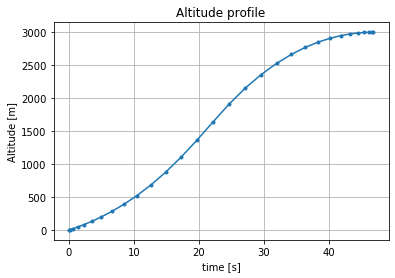

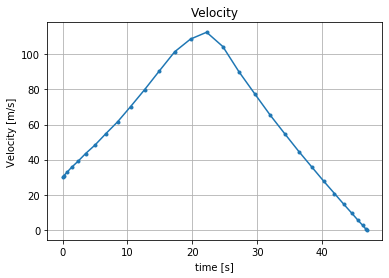

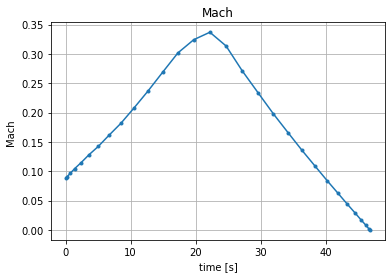

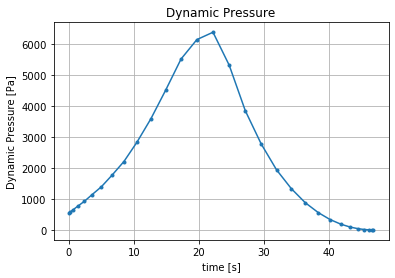

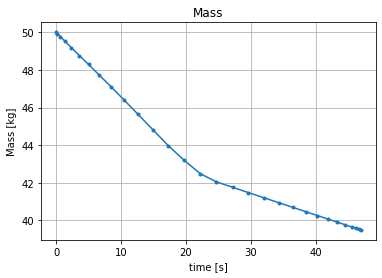

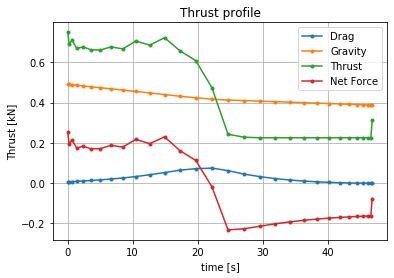

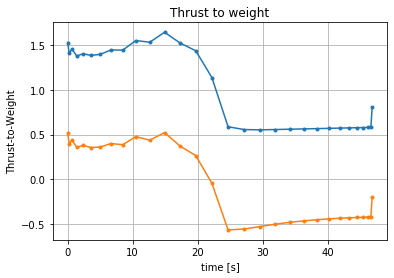

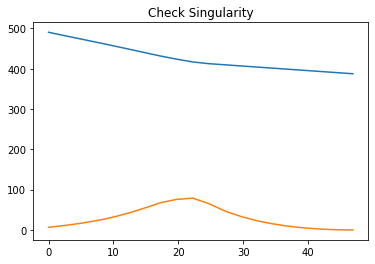

In [25]:
flag_savefig = True
savefig_file = "./Boosted_Single_Stage/M0_30kg/"
prob.to_csv()
prob.to_csv(savefig_file+ 'output.csv')

# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
h = prob.states_all_section(0)
v = prob.states_all_section(1)
m = prob.states_all_section(2)
T = prob.controls_all_section(0)
time = prob.time_update()

rho = obj.air_density(h)
q = (1/2)*rho*v**2
a = obj.speed_of_sound(h)
M = v/a

# ------------------------
# Calculate necessary variables

drag = obj.drag(h,v)
g0   = obj.g0

# ------------------------
# Visualizetion
plt.figure()
plt.title("Altitude profile")
plt.plot(time, h, marker=".", label="Altitude")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Altitude [m]")
if(flag_savefig): plt.savefig(savefig_file + "altitude" + ".png")

plt.figure()
plt.title("Velocity")
plt.plot(time, v, marker=".", label="Velocity")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Velocity [m/s]")
if(flag_savefig): plt.savefig(savefig_file + "velocity" + ".png")
    
plt.figure()
plt.title("Mach")
plt.plot(time, M, marker=".", label="Mach")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mach ")
if(flag_savefig): plt.savefig(savefig_file + "mach" + ".png")
    
plt.figure()
plt.title("Dynamic Pressure")
plt.plot(time, q, marker=".", label="Dynamic Pressure")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Dynamic Pressure [Pa]")
if(flag_savefig): plt.savefig(savefig_file + "dynamicPressure" + ".png")

plt.figure()
plt.title("Mass")
plt.plot(time, m, marker=".", label="Mass")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mass [kg]")
if(flag_savefig): plt.savefig(savefig_file + "mass" + ".png")

plt.figure()
plt.title("Thrust profile")
plt.plot(time, drag / 1000, marker=".", label="Drag")
plt.plot(time, m * g0 / 1000, marker=".", label="Gravity")
plt.plot(time, T / 1000, marker=".", label="Thrust")
plt.plot(time, (T - drag - m*g0)/ 1000, marker=".", label="Net Force")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust [kN]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "force" + ".png")
    
plt.figure()
plt.title("Thrust to weight")
plt.plot(time, T/(m*g0), marker=".", label='Thrust to weight')
plt.plot(time, (T - drag - m*g0)/(m*g0), marker='.', label='Net force to weight ratio')
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust-to-Weight")
if(flag_savefig): plt.savefig(savefig_file + "T-to-W" + ".png")
    
plt.figure()
plt.title('Check Singularity')
plt.plot(time, m*g0)
plt.plot(time, (1+v/(obj.Isp*g0))*drag)

plt.show()

In [26]:
propmass = m[0]-m[-1]

In [27]:
propmass

10.501547963078906

In [28]:
propmass/m[0]

0.2100309592615781

In [29]:
propmass*obj.Isp*9.81

20604.037103560815

In [30]:
obj.Isp*g0

1961.33

In [31]:
v_min = 30.5 #minimum launch rail clearance speed
s = 5 #launch rail length
a_min = v_min**2/(2*s)
F_min = a_min*obj.M_0
t_min = v_min/a_min

In [32]:
F_min

4651.25

In [33]:
obj.T_max

750

In [34]:
T

array([748.68191108, 689.79096465, 709.39590873, 668.02253194,
       676.19325296, 661.61982049, 660.4851375 , 675.87938192,
       666.2231924 , 704.95317807, 684.82970528, 721.58413524,
       656.659322  , 607.9526108 , 473.71919364, 242.1908508 ,
       227.90725714, 225.        , 225.        , 225.        ,
       225.00458233, 225.        , 225.00206973, 225.        ,
       225.        , 225.        , 225.        , 225.        ,
       225.98707308, 310.84433571])

In [35]:
np.trapz(x= time, y = T)

20605.096880868878

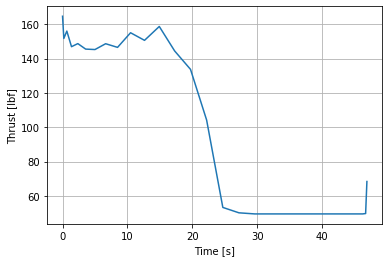

In [36]:
plt.plot(time,T*0.22)
plt.xlabel('Time [s]')
plt.ylabel('Thrust [lbf]')
plt.grid()